# Cpoke ITI analysis for Figure 4


In [1]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, friedmanchisquare, wilcoxon
import statsmodels.formula.api as smf
import itertools

sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
pdf = u.load_poke_df()
pdf["prev_was_valid"] = (
    pdf
    .groupby(["animal_id", "date"])["was_valid"]
    .shift(1)
)

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


## Grow Stages


In [3]:
gdf = pdf.query("stage in @c.GROWING_STAGES").copy()
violation_penalty_timeout = 2
gdf['cpoke_iti_no_timeout'] = np.where(
    gdf['fix_experiment'] == 'V2',
    gdf['cpoke_iti'],
    np.where(
        gdf['post_settling_violation'],
        gdf['cpoke_iti'] - violation_penalty_timeout,
        gdf['cpoke_iti']
    )
)


In [4]:
def filter_df_by_percentile(df, column='cpoke_iti_no_timeout', percentile=0.90):
    """
    Filters the dataframe by removing rows where the value in `column` exceeds the given percentile for each animal_id.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column (str): Column on which to compute the percentile.
        percentile (float): The percentile threshold (e.g., 0.99 for the 99th percentile).
    
    Returns:
        pd.DataFrame: A filtered DataFrame.
    """
    # Compute the threshold for each animal_id group using transform
    threshold = df.groupby('animal_id')[column].transform(lambda x: x.quantile(percentile))
    # Filter rows where the column value is less than or equal to the threshold
    filtered_df = df[df[column] <= threshold]
    return filtered_df

gdf = filter_df_by_percentile(gdf, column='cpoke_iti_no_timeout', percentile=0.99)
gdf = gdf.query("cpoke_iti_no_timeout > 0")

### Plots


Text(0.5, 1.0, 'V1 vs V2 ITI Distribution')

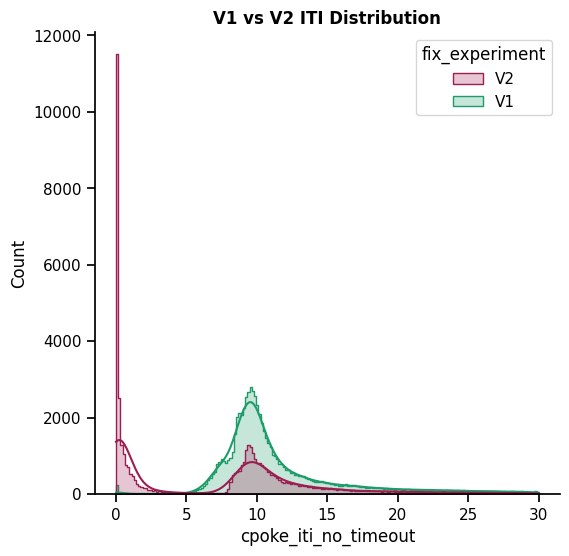

In [5]:
MAX_ITI=30
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
sns.histplot(
    data=gdf.query("cpoke_iti_no_timeout < @MAX_ITI"),
    x="cpoke_iti_no_timeout",
    ax=ax,
    hue="fix_experiment",
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)
ax.set_title("V1 vs V2 ITI Distribution", fontweight="bold")

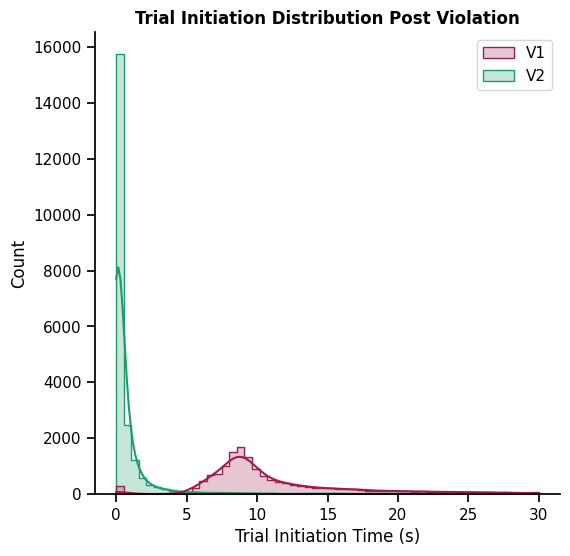

In [33]:
MAX_ITI=30
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
sns.histplot(
    data=gdf.query("cpoke_iti_no_timeout < @MAX_ITI and prev_was_valid==False"),
    x="cpoke_iti_no_timeout",
    ax=ax,
    hue="fix_experiment",
    hue_order=c.HUE_ORDER_EXP,
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)
ax.set_title("Trial Initiation Distribution Post Violation", fontweight="bold")

ax.set(
    xlabel="Trial Initiation Time (s)",
)

ax.get_legend().set_title("")


<bound method Axes.set of <Axes: xlabel='fix_experiment', ylabel='cpoke_iti_no_timeout'>>

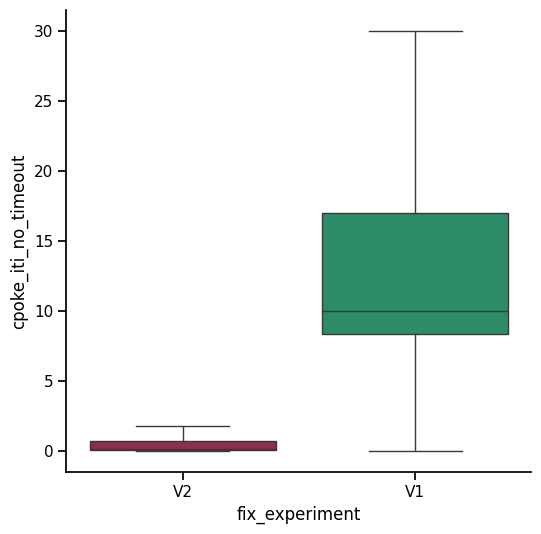

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

MAX_ITI = 30
sns.boxplot(
    data=gdf.query("prev_was_valid == False"),
    y="cpoke_iti_no_timeout",
    ax=ax,
    x="fix_experiment",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
   showfliers=False,
)
ax.set


<bound method Axes.set of <Axes: xlabel='prev_was_valid', ylabel='cpoke_iti_no_timeout'>>

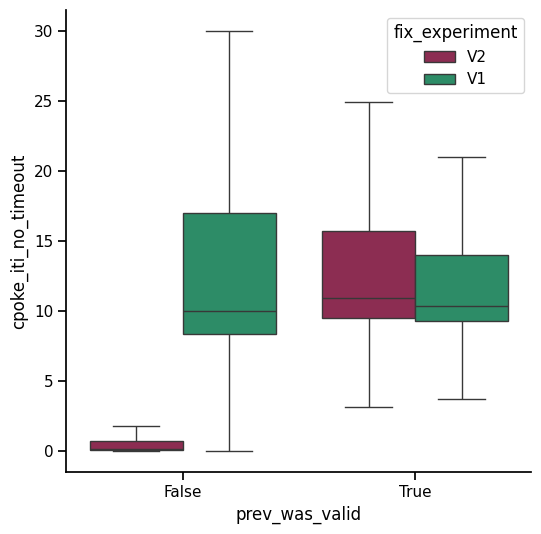

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

MAX_ITI = 30
sns.boxplot(
    data=gdf,
    y="cpoke_iti_no_timeout",
    ax=ax,
    x="prev_was_valid",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
   showfliers=False,
)
ax.set


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
try:
    from scikit_posthocs import posthoc_dunn
except ImportError:
    raise ImportError("Please install scikit-posthocs (pip install scikit-posthocs) to use Dunn post-hoc.")

def compare_four_groups(df, metric_col, alpha=0.05):
    """
    Compare four groups defined by:
        1) fix_experiment = V1, prev_was_valid = False
        2) fix_experiment = V2, prev_was_valid = False
        3) fix_experiment = V1, prev_was_valid = True
        4) fix_experiment = V2, prev_was_valid = True

    Using:
        - Kruskal–Wallis as the omnibus test
        - Dunn test (with Bonferroni correction) for post-hoc comparisons.

    Returns a tidy DataFrame: 
        - The first row is the omnibus test (Kruskal).
        - Subsequent rows are pairwise comparisons (Dunn).

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: 'fix_experiment', 'prev_was_valid', and `metric_col`.
    metric_col : str
        The numeric variable to compare across the 4 groups.
    alpha : float, optional
        Significance level (default 0.05). 
        (Note: alpha is not explicitly used in the omnibus or post-hoc 
        except to interpret results if you wish.)

    Returns
    -------
    pd.DataFrame
        Tidy DataFrame summarizing the Kruskal–Wallis and Dunn post-hoc tests.
    """
    # 1) Subset the four groups
    g1 = df[(df['fix_experiment'] == 'V1') & (df['prev_was_valid'] == False)][metric_col].dropna()
    g2 = df[(df['fix_experiment'] == 'V2') & (df['prev_was_valid'] == False)][metric_col].dropna()
    g3 = df[(df['fix_experiment'] == 'V1') & (df['prev_was_valid'] == True)][metric_col].dropna()
    g4 = df[(df['fix_experiment'] == 'V2') & (df['prev_was_valid'] == True)][metric_col].dropna()

    # 2) Kruskal–Wallis omnibus test
    kw_stat, kw_p_val = kruskal(g1, g2, g3, g4)

    results_list = []

    # Omnibus row
    results_list.append({
        "comparison": "omnibus",
        "test_type": "kruskal",
        "test_statistic": kw_stat,
        "p_val_raw": kw_p_val
    })

    # 3) Dunn post-hoc
    # Prepare data for scikit-posthocs
    data_concat = pd.concat([g1, g2, g3, g4], axis=0)
    group_labels = (
        ["V1_False"] * len(g1) +
        ["V2_False"] * len(g2) +
        ["V1_True"]  * len(g3) +
        ["V2_True"]  * len(g4)
    )
    posthoc_df = pd.DataFrame({"values": data_concat, "group": group_labels})

    # Dunn test with Bonferroni correction
    dunn_res = posthoc_dunn(
        posthoc_df, 
        val_col="values", 
        group_col="group", 
        p_adjust="bonferroni"
    )

    # dunn_res is a matrix of p-values for each pair
    unique_groups = dunn_res.index.tolist()
    for i, gA in enumerate(unique_groups):
        for j, gB in enumerate(unique_groups):
            if j <= i:
                # Avoid duplicates / diagonal
                continue
            p_ij = dunn_res.loc[gA, gB]
            results_list.append({
                "comparison": f"{gA} vs {gB}",
                "test_type": "dunn",
                "test_statistic": None,  # Dunn doesn't provide a single statistic
                "p_val_raw": p_ij
            })

    # 4) Return as a tidy DataFrame
    return pd.DataFrame(results_list)

In [12]:
compare_four_groups(gdf, metric_col = "cpoke_iti_no_timeout")

,comparison,test_type,test_statistic,p_val_raw
0,omnibus,kruskal,47344.696081,0.000000e+00
1,V1_False vs V1_True,dunn,NaN,1.890235e-40
2,V1_False vs V2_False,dunn,NaN,0.000000e+00
3,V1_False vs V2_True,dunn,NaN,2.977531e-176
4,V1_True vs V2_False,dunn,NaN,0.000000e+00
5,V1_True vs V2_True,dunn,NaN,5.632917e-105
6,V2_False vs V2_True,dunn,NaN,0.000000e+00


## Probe Stages


In [34]:
prdf = pdf.query("stage in @c.PROBE_STAGES and settling_violation == False").copy()
violation_penalty_timeout = 2
prdf['cpoke_iti_no_timeout'] = np.where(
        prdf['post_settling_violation'],
        prdf['cpoke_iti'] - violation_penalty_timeout,
        prdf['cpoke_iti']
)
prdf = filter_df_by_percentile(prdf, column='cpoke_iti_no_timeout', percentile=0.99)
prdf = prdf.query("cpoke_iti_no_timeout > 0")

Text(0.5, 1.0, 'Probe Stages\nTrial Initiation Distribution Post Violation')

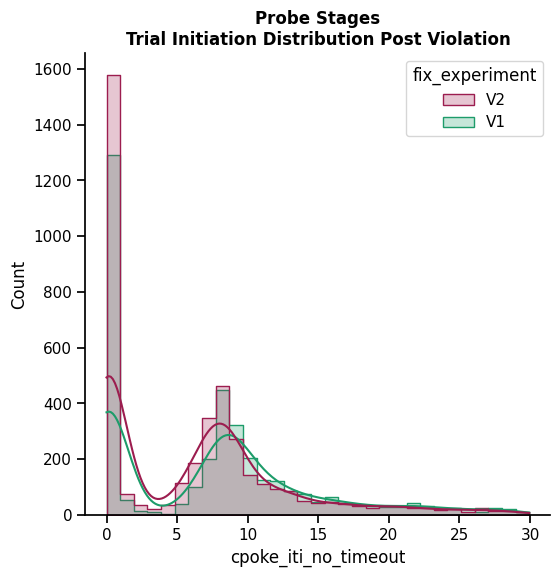

In [40]:
MAX_ITI=30
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()
sns.histplot(
    data=prdf.query("cpoke_iti_no_timeout < @MAX_ITI and prev_was_valid==False"),
    x="cpoke_iti_no_timeout",
    ax=ax,
    hue="fix_experiment",
    kde=True,
    element="step",
    palette =c.EXP_PALETTE,
)
ax.set_title("Probe Stages\nTrial Initiation Distribution Post Violation", fontweight="bold")

<Axes: xlabel='fix_experiment', ylabel='cpoke_iti_no_timeout'>

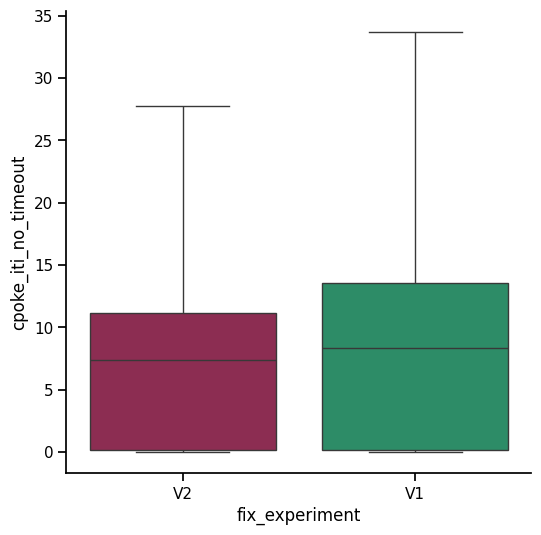

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

sns.boxplot(
    data=prdf.query("prev_was_valid == False"),
    y="cpoke_iti_no_timeout",
    ax=ax,
    x="fix_experiment",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
   showfliers=False,
)


<Axes: xlabel='prev_was_valid', ylabel='cpoke_iti_no_timeout'>

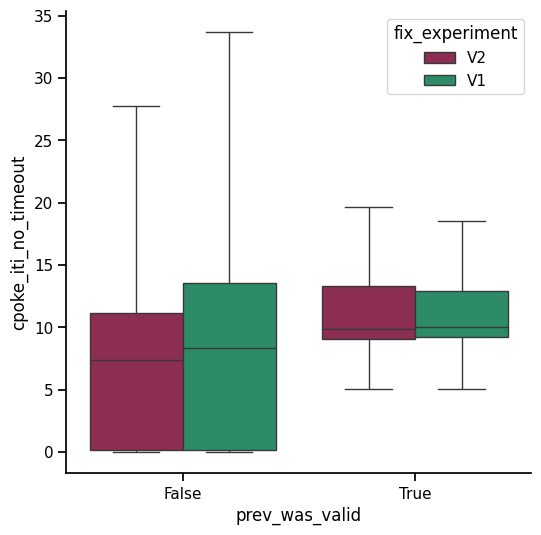

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
sns.despine()

MAX_ITI = 30
sns.boxplot(
    data=prdf,
    y="cpoke_iti_no_timeout",
    ax=ax,
    x="prev_was_valid",
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
   showfliers=False,
)


In [19]:
compare_four_groups(prdf, metric_col = "cpoke_iti_no_timeout")

,comparison,test_type,test_statistic,p_val_raw
0,omnibus,kruskal,3393.466927,0.000000e+00
1,V1_False vs V1_True,dunn,NaN,1.801527e-253
2,V1_False vs V2_False,dunn,NaN,6.494127e-25
3,V1_False vs V2_True,dunn,NaN,3.873264e-214
4,V1_True vs V2_False,dunn,NaN,0.000000e+00
5,V1_True vs V2_True,dunn,NaN,5.842473e-07
6,V2_False vs V2_True,dunn,NaN,0.000000e+00
